# An Introduction to Information Theory

* Basics
    * Entropy
    * Joint Entropy
    * Conditional Entropy
    * Mutual Information
    * KL Divergence
    * Conditional Mutual Information
* Trees
    * Decision Tree (C4.5)
        * Universal Approximators
        * Example
        * Psuedo Code
        * Algorithm Implementation
        * feature importances
        * tree interpretter
        * SHAP
    * Random Forests
        * High Level Psuedo Code
        * Example
        * tree interpretter
        * SHAP
    * Gradient Boosted Trees
        * High Level Psuedo Code
        * Example
        * tree interpretter
        * SHAP
    * XG-Boosted Trees
        * Differences from Gradient Boosted Trees
        * Example
        * tree interpretter
        * SHAP
    * Cat Boost
        * Use-Case
        * Example
        * SHAP

## Information Theory Basics

### A quick review of the probability:

The _probability_ of an event X is how likely it is to occur over the long term.

Example:

What is the probability that if you flip a coin it comes up heads?

Given two cases:

* Heads
* Tails

The result should be:

$$ \frac{\textrm{Desired Case}}{\textrm{Total Cases}} $$

Therefore:

$$ \frac{\textrm{Head Case}}{\textrm{Total Cases}} = \frac{1}{2} $$

In [35]:
import random

def generate_coin_flips(n):
    cases = ["H", "T"]
    probabilities = {
        'H': 0,
        'T': 0
    }
    for _ in range(n):
        probabilities[random.choice(cases)] += 1
    return {case:probabilities[case]/n for case in probabilities}

generate_coin_flips(10)

{'H': 0.3, 'T': 0.7}

In this case we got tails more frequently than heads!  Does that mean we got it wrong?! No!

That's because we end up with 50% probability over the long run.  Let's see how many times we need to flip a coin for the number of times to get 50% probability!

In [8]:
generate_coin_flips(999999)

{'H': 50049.3, 'T': 49950.6}

As you can see we get closer.  Let's see the path to 50% heads:

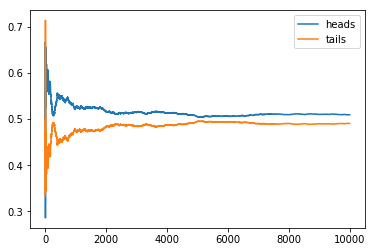

In [22]:
import random
import matplotlib.pyplot as plt
%matplotlib inline

def generate_coin_flips(n):
    cases = ["H", "T"]
    occurrences = [random.choice(cases) for _ in range(n)]
    probabilities = []
    for index in range(len(occurrences)):
        if occurrences[:index].count("H") == 0 or occurrences[:index].count("T") == 0:
            continue
        probabilities.append({
            "H": occurrences[:index].count("H")/index,
            "T": occurrences[:index].count("T")/index
        })
    return probabilities

probabilities = generate_coin_flips(10000)

x = list(range(len(probabilities)))
heads = [probabilities[index]["H"] for index in range(len(probabilities))]
tails = [probabilities[index]["T"] for index in range(len(probabilities))]
plt.plot(x, heads, label="heads")
plt.plot(x, tails, label="tails")
plt.legend()

As we can see, the probabilities diverge wildly for the first few flips and then eventually they normalize to close to 50% each.  This is what the probability really is saying, it's the likelihood of the event eventually, over many trials.

This is known as the [Law of Large Numbers](https://en.wikipedia.org/wiki/Law_of_large_numbers) and is possibly the most important theorem in probability and statistics for non-time series data.

## Entropy

Now that we've looked at the basics of probability, let's look at our first information theoretic notion - Entropy.   Generally, information entropy is the average amount of information conveyed by an event, when considering all possible outcomes.

The formula for Entropy is:

$$ H = - \sum_{i} p_{i} log_{2}p_{i}  $$

Entropy comes to us from information theory, primarily used for encoding symbols on a wire.  To understand this, consider wanting to create a binary encoding of the alphabet to pass along a wire.  Would you use the same number of symbols for each letter?  Or would some symbols use shorter encodings so they can be passed along the wire more easily?  It turns out we can decide how to encode each letter of the alphabet in this scenario using a probabilistic approach.  That is, we can start with a uniform encoding scheme and then observe the probability of each symbol across the wire.  We can then observe the probabilities of each symbol and adjust our encoding to minimize entropy.  This represents the numbering system in the encoding via the subscript of the log - so a log base 2 assumes a binary encoding scheme.  log base 3 assumes a trianary encoding scheme and so on.


Interestingly, entropy's uses extend well beyond it's initial use case.  As you can see the Entropy makes use of the probability.  As the equation shows us, Entropy is a scaled negative of the probability mass function.  So we can see entropy as sort of like the inverse of a probability.  Two common descriptions of Entropy beyond it's initial use case:

* The 'surprise' of an event - IE low probability events carry more information than more common events.  That's because if a more common event occurs, we get the predictable outcome.  But if a very unlikely event occurs, we learn a lot from that trial, even more so, we learn a lot about that system.
* The disorder within a system 

Interestingly, when all events are equally likely the entropy is maximized.

So for example:

Say we wanted to figure out if a dice was fair, we could use entropy to measure if it is indeed fair:

In [39]:
import random
import math

def generate_dice_rolls(cases, n):
    probabilities = {
        1: 0,
        2: 0,
        3: 0,
        4: 0,
        5: 0, 
        6: 0
    }
    for _ in range(n):
        probabilities[random.choice(cases)] += 1
    return {case:probabilities[case]/n for case in probabilities}

def entropy(probabilities):
    return -1 * sum([probabilities[case]*math.log(probabilities[case]) 
                     for case in probabilities])

cases = [1, 2, 3, 4, 4, 4, 5, 5, 6]
probabilities = generate_dice_rolls(cases, 1000)
print("Weighted Dice", entropy(probabilities))
cases = [1,2,3,4,5,6]
probabilities = generate_dice_rolls(cases, 1000)
print("Fair Dice", entropy(probabilities))

Weighted Dice 1.6598301582773598
Fair Dice 1.7903953067307885


Notice, we are able easily discern that the entropy is smaller for the weighted or "biased" dice compared to the fair dice.  This notion will be important when we go over trees.

## Joint Probability

The joint probability is the probability of two events occurring at the same time.  Assuming the events are mutually exclusive, meaning they don't depend on each other, then the formula is:

$$ p(x, y) = p(x) * p(y) $$

Assuming the events depend on each other we then have a dependency structure to our joint probability:

$$ p(x, y) = p(x | y) * p(y) $$

-OR-

$$ p(x, y) = p(y | x) * p(x) $$

Let's see how the first case looks:

Assume you have two fair dice, what's the probability of getting two 1's, aka snake eyes?

Formmally that is:

$$ Pr(X=1 | Y=1) = \frac{1}{6} * \frac{1}{6} = \frac{1}{36}$$

Now let's see how to calculate this programmatically:

In [11]:
import random
import math
import itertools

def generate_dice_rolls_joint(cases, n):
    total_cases = [elem for elem in itertools.permutations(cases, 2)] + [(elem, elem) for elem in cases]
    probabilities = {}.fromkeys(total_cases, 0)
    for _ in range(n):
        probabilities[random.choice(total_cases)] += 1
    return {case:probabilities[case]/n for case in probabilities}

cases = [1,2,3,4,5,6]
probabilities = generate_dice_rolls_joint(cases, 999999)
probabilities

{(1, 2): 0.02767902767902768,
 (1, 3): 0.027735027735027735,
 (1, 4): 0.027605027605027605,
 (1, 5): 0.027613027613027613,
 (1, 6): 0.027728027728027727,
 (2, 1): 0.027853027853027852,
 (2, 3): 0.02794702794702795,
 (2, 4): 0.02783802783802784,
 (2, 5): 0.027456027456027456,
 (2, 6): 0.028107028107028108,
 (3, 1): 0.02796802796802797,
 (3, 2): 0.02774202774202774,
 (3, 4): 0.0278990278990279,
 (3, 5): 0.027945027945027946,
 (3, 6): 0.02791002791002791,
 (4, 1): 0.027703027703027704,
 (4, 2): 0.027587027587027586,
 (4, 3): 0.027682027682027682,
 (4, 5): 0.02783202783202783,
 (4, 6): 0.02762102762102762,
 (5, 1): 0.027755027755027754,
 (5, 2): 0.0279000279000279,
 (5, 3): 0.02767902767902768,
 (5, 4): 0.027773027773027772,
 (5, 6): 0.0277990277990278,
 (6, 1): 0.02775102775102775,
 (6, 2): 0.02804102804102804,
 (6, 3): 0.02791902791902792,
 (6, 4): 0.027619027619027618,
 (6, 5): 0.027886027886027887,
 (1, 1): 0.02755002755002755,
 (2, 2): 0.027816027816027815,
 (3, 3): 0.0277070277070277

Here most of the probabilities are around 0.027 which is approximately $ \frac{1}{36} $.  So we were able to recover a calculation which matches approximately with our theoretical guess!

Now let's look at a case where the probability of a given random variable is dependent on another random variable:

For this let's assume we are playing a simple card game:  

What's the probability of drawing the 3 of diamonds and drawing a heart?

$$ Pr(\textrm{3 of diamonds}|heart) * Pr(heart) * 2= \frac{1}{51} * \frac{13}{52} * 2= \frac{26}{2652} $$

In [16]:
import random
import math
import itertools
import collections

# Stolen from here: https://github.com/fluentpython/example-code/blob/master/01-data-model/frenchdeck.py
Card = collections.namedtuple('Card', ['rank', 'suit'])

class FrenchDeck:
    ranks = [str(n) for n in range(2, 11)] + list('JQKA')
    suits = 'spades diamonds clubs hearts'.split()

    def __init__(self):
        self._cards = [Card(rank, suit) for suit in self.suits
                                        for rank in self.ranks]

    def __len__(self):
        return len(self._cards)

    def __getitem__(self, position):
        return self._cards[position]
    
def generate_conditional_deck_joint_probability(deck, n):
    total_cases = [elem for elem in itertools.combinations(deck, 2)] 
    probabilities = {}.fromkeys(total_cases, 0)
    for _ in range(n):
        probabilities[random.choice(total_cases)] += 1
    probabilities = {case:probabilities[case]/n for case in probabilities}
    cases_of_interest = {}
    for case in probabilities:
        first_condition = case[0].suit == "diamonds"
        second_condition = case[0].rank == '3'
        third_condition = case[1].suit == "hearts"
        if first_condition and second_condition and third_condition:
            cases_of_interest.update({case: probabilities[case]})
    return sum(list(cases_of_interest.values()))

   
deck = FrenchDeck()
probabilities = generate_conditional_deck_joint_probability(deck, 999999)
probabilities

0.00984300984300984

Just to verify: 

$$ \frac{26}{2652} \approx 0.0098 $$

Which is pretty close to what we got!

## Joint Entropy

Now that we have the notion of joint probability we can analyze the joint entropy of two random variables.  The notions here are more or less the same - assuming the random variables are independent, the joint entropy is the joint 'surprise' of two events.  If the joint probability of all events in the space are equally likely, then the event space is said to be maximized.

Let's look at the formula for joint entropy:

$$ H(X, Y) = - \sum_{x,y} \textrm{p(x, y) log p(x,y)} $$

Returning to our dice example, let's consider two cases now:

1. When the dice are fair
2. When the dice are weighted

Weighted dice are employed by charlatans to deceive gamblers out of money.  So, we can test empirically whether or not a pair of dice are weighted, if we wish to inspect whether or not a casino uses fair dice, as follows:

In [17]:
import random
import math
import itertools

def generate_dice_rolls_joint(cases, n):
    total_cases = [elem for elem in itertools.permutations(cases, 2)] + [(elem, elem) for elem in cases]
    probabilities = {}.fromkeys(total_cases, 0)
    for _ in range(n):
        probabilities[random.choice(total_cases)] += 1
    return {case:probabilities[case]/n for case in probabilities}

def entropy(probabilities):
    return -1 * sum([probabilities[case]*math.log(probabilities[case]) 
                     for case in probabilities])

cases = [1, 2, 3, 4, 4, 4, 5, 5, 6]
probabilities = generate_dice_rolls_joint(cases, 1000)
print("Weighted Dice", entropy(probabilities))
cases = [1,2,3,4,5,6]
probabilities = generate_dice_rolls_joint(cases, 1000)
print("Fair Dice", entropy(probabilities))

Weighted Dice 3.3438375882883706
Fair Dice 3.5679159556113405


Notice that in this case the code for calculating entropy doesn't change, this is because we implicitly have a joint probability from the calculation above.

Also, notice that the weighted dice has a lower entropy than the fair dice showing, in fact, we can discern entropy in a multivariate state reliably.

## Conditional Joint Entropy

Now that we now how to handle the case when there is some dependency between the two random variables.  First let's right down the formula:

$$ H(X|Y) = - \sum_{y \in Y} p(y) \sum_{x \in X} \textrm{p(x|y) log p(x|y)} = - \sum_{x,y} \textrm{p(x,y) log p(x|y)} $$

As you can see from the above definition we consider the the total probability of y and the probability of X conditioned on Y.  So we can treat the conditional joint entropy of X given Y as the average conditional entropy over Y.

More generally, we can think of the conditional joint entropy as the surprise of X given Y.

Returning to our example from choosing cards, we can use the conditional joint entropy to tell if two decks (or possibly two dealers) are fair.  If they are, the conditional joint entropy should be maximized:


In [19]:
import random
import math
import itertools
import collections

# Stolen from here: https://github.com/fluentpython/example-code/blob/master/01-data-model/frenchdeck.py
Card = collections.namedtuple('Card', ['rank', 'suit'])

class FairFrenchDeck:
    ranks = [str(n) for n in range(2, 11)] + list('JQKA')
    suits = 'spades diamonds clubs hearts'.split()

    def __init__(self):
        self._cards = [Card(rank, suit) for suit in self.suits
                                        for rank in self.ranks]

    def __len__(self):
        return len(self._cards)

    def __getitem__(self, position):
        return self._cards[position]

class UnfairFrenchDeck:
    ranks = [str(n) for n in range(2, 11)] + list('JQKA')
    suits = 'spades diamonds clubs hearts'.split()

    def __init__(self):
        self._cards = [Card(rank, suit) for suit in self.suits
                                        for rank in self.ranks]
        # making hearts and diamonds more likely than spades or clubs
        self._cards += [Card(rank, suit) for suit in ["hearts", "diamonds"]
                                         for rank in self.ranks]

    def __len__(self):
        return len(self._cards)

    def __getitem__(self, position):
        return self._cards[position]

def generate_conditional_deck_joint_probabilities(deck, n):
    total_cases = [elem for elem in itertools.combinations(deck, 2)] 
    probabilities = {}.fromkeys(total_cases, 0)
    for _ in range(n):
        probabilities[random.choice(total_cases)] += 1
    probabilities = {case:probabilities[case]/n 
                     for case in probabilities}
    cases_of_interest = {}
    for case in probabilities:
        first_condition = case[0].suit == "diamonds"
        second_condition = case[0].rank == '3'
        third_condition = case[1].suit == "hearts"
        if first_condition and second_condition and third_condition:
            cases_of_interest.update({case: probabilities[case]})
    return cases_of_interest

def generate_deck_probabilities(deck, n):
    total_cases = [card for card in deck if card.suit == "hearts"]
    probabilities = {}.fromkeys(total_cases, 0)
    for _ in range(n):
        probabilities[random.choice(total_cases)] += 1
    return {case:probabilities[case]/n 
           for case in probabilities}
    
def conditional_entropy(probabilities, joint_probabilities):
    p_y = sum(list(probabilities.values()))
    p_x_given_y = sum([joint_probabilities[case]*math.log(joint_probabilities[case]) 
                     for case in joint_probabilities])
    return -1 * p_y * p_x_given_y 

fair_deck = FairFrenchDeck()
n = 999999
joint_probabilities = generate_conditional_deck_joint_probabilities(fair_deck, n)
probabilities = generate_deck_probabilities(fair_deck, n)
print("Fair deck, Conditional Joint Entropy", conditional_entropy(probabilities, joint_probabilities))
unfair_deck = UnfairFrenchDeck()
joint_probabilities = generate_conditional_deck_joint_probabilities(unfair_deck, n)
probabilities = generate_deck_probabilities(unfair_deck, n)
print("Unfair deck, Conditional Joint Entropy", conditional_entropy(probabilities, joint_probabilities))

Fair deck, Conditional Joint Entropy 0.07114769929362579
Unfair deck, Conditional Joint Entropy 0.06308279612598472


As we can see, the entropy is maximized when the deck is fair!  So, we could watch the hands that are dealt at a given casino and if the entropy of all observed hands doesn't meet the conditional joint entropy, then it's likely there is some foul play at foot!

## Cross Entropy 

Cross Entropy is best described initially with a return to it's first use case - encoding information on a wire.  Suppose you have two communication channels - both channels are in english and use the same alphabet.  What if you want to how different the optimal encoding scheme is for one channel versus another.  This is a perfect use case for cross entropy!

$$ H(p, q) = - \sum_{x \in X} p(x) log q(x) $$

As you can see from the equation, we look at the same space of symbols needed to be encoded, IE, the same space of data to be measured and to _distinct_ probability distributions for the data.  

The Cross Entropy can tell us how similar the two probability distributions are, in terms of information gain.  When they are the same the cross entropy is as small as possible, that is when `p = q`.  

Cross Entropy is also a great measure for comparing observed data versus that for a model in binary or multi class classification.  Recall that a model is merely an application maximum likelihood estimation (MLE), IE recovering the most likely fit parameters for a multi-variate distribution.  Therefore, when we make use of cross entropy we are assessing our the quality of our data generated by first applying MLE and comparing it to the "natural generation process" that supplied us with our ground truth data.

The lower the cross entropy, the closer the model is to the observed dataset.  And therefore, we can expect our model or synthetic data generation process, to be closer the process that generated our data.

Let's look at our first real world example of entropy, for this we'll make use of some sklearn magic!

In [44]:
from sklearn.datasets import load_iris
from sklearn import ensemble
from sklearn import metrics

data = load_iris()
rf = ensemble.RandomForestClassifier()
rf.fit(data.data, data.target)
y_pred = rf.predict_proba(data.data)
metrics.log_loss(data.target, y_pred)

/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.03067323365612531

As you can see, the cross entropy is quiet small, so we can likely trust the model does a very good job.  Notice that the cross entropy assumes your model predictions are in terms of probabilities for the predicted results.  In case you are wondering of how well this model does in terms of precision and recall:

In [46]:
y_pred = rf.predict(data.data)
print(metrics.classification_report(data.target, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.96      1.00      0.98        50
           2       1.00      0.96      0.98        50

   micro avg       0.99      0.99      0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150



As you can see, this model essentially gets everything right in terms of precision _and_ recall!  In fact it correctly classifies all of the examples from 2 out of the three classes!!!

## Mutual Information


Mutual information is a measure of how much information is shared between two variables.  To understand the motivation behind this measure let's return again to our original context of encoding information on a wire.  Mutual information in specific measures the distribution of data before it is sent across a wire and after.  It's formula is expressed as:

$$ I(X;Y) = \sum_{x,y} p(x,y) log \frac{p(x,y)}{p(x)p(y)} $$

This formula more or less compares the ratio in information between the joint probability of the variables taken together against the marginal probabilities being composed.  Notice that if the variables are independent than this ratio is 1 and if the variables are the same, this ratio is 0.  Since `log 1 = 0`, when the variables are independent the mutual information is zero and when the two variables are the same the mutual information is maximized.

Using the above analysis, we can see that mutual information can be used to measure independence between two variables.  In general, the mutual information is a measure on the information gained between two variables.  Returning to our example of information passing over a wire, we can see mutual information as how much information gain we observe from the received messages as compared with the sent.  So we can assess whether or not the wire has manipulated the distribution across an action.

One of the nice properties of mutual information as a measure is, it does not assume an underlying distribution about it's two random variables.  Thus we have a general purpose measure of independence.

Let's look at a few worked examples:

In [47]:
from sklearn import feature_selection
import seaborn as sns
crashes = sns.load_dataset("car_crashes").sort_values("total", ascending=False)

crashes.head()

,total,speeding,alcohol,not_distracted,no_previous,ins_premium,ins_losses,abbrev
40,23.9,9.082,9.799,22.944,19.359,858.97,116.29,SC
34,23.9,5.497,10.038,23.661,20.554,688.75,109.72,ND
48,23.8,8.092,6.664,23.086,20.706,992.61,152.56,WV
3,22.4,4.032,5.824,21.056,21.280,827.34,142.39,AR
17,21.4,4.066,4.922,16.692,16.264,872.51,137.13,KY


In [56]:
features = ["speeding", "alcohol", "not_distracted", "no_previous", "ins_premium"]
X = crashes[features]
y = crashes["total"]
ranks = feature_selection.mutual_info_regression(X, y)
rankings = []
for index, feature in enumerate(features):
    rankings.append((feature, ranks[index]))
sorted(rankings, key=lambda t: t[1], reverse=True)

[('not_distracted', 1.1122296149948283),
 ('no_previous', 1.0650950506291723),
 ('alcohol', 0.6553972972460005),
 ('speeding', 0.3147170761329834),
 ('ins_premium', 0.0988608669016986)]

Here we see the `not_distracted` has the highest mutual information, so we should expect it to be a good predictor for total car crashes per 50,000 miles.  Interestingly, we can also make use of mutual information as a measure of the fit of for a given model:

In [60]:
from sklearn import ensemble
from sklearn import metrics

features = ["alcohol", "not_distracted", "no_previous"]
X = crashes[features]
y = crashes["total"]
gbt = ensemble.GradientBoostingRegressor()
gbt.fit(X, y)
y_pred = gbt.predict(X)
metrics.mutual_info_score(y, y_pred)

3.768732178474927

So we can say there is likely some mutual information between the predicted and seen target column!  This means this model is probably at least an okay fit.

## KL - Divergence

KL-Divergence is a way of comparing a true distribution against some arbitrary probability distribution.  We can think of it as the "unnecessary surprise" from a model to some true model.  

$$ D_{KL}(p(X)||q(X)) = \sum_{x \in X} p(x) log \frac{p(x)}{q(x)} $$

As you can see, the KL-Divergence is the ratio of the correct distribution to the arbitrary distribution.  KL-Divergence is a natural fit for assessing the divergence in a supervised learning problem.  Let's look at an example:

In [66]:
from sklearn import ensemble
from sklearn import metrics
from scipy import stats

features = ["alcohol", "not_distracted", "no_previous"]
X = crashes[features]
y = crashes["total"]
gbt = ensemble.GradientBoostingRegressor()
gbt.fit(X, y)
y_pred = gbt.predict(X)
stats.entropy(y, qk=y_pred)

1.5176955469736423e-05

As you can see the divergence is quite small.  So we can say this model is probably a good fit!  Note - KL divergence is not a true metric because it does not satisfy the triangle inequality and is therefore not well ordered.  Therefore you cannot use it as a comparison between two models.  However, it is still used often across many algorithms and can be used in many contexts, because of it's flexability.  

# Trees

Now that we under how Entropy works, we can look at a class of models that make use of it to model data - Tree based models!  At a very high level, Tree based models are universal approximators, in that they don't require _any_ distribution information to fit data.  In fact, the only cases they tend to do really poorly on are those where the data is very clearly linearly seperated.  This is because of how tree based models fit the data.  But rather than tell you about it - let's look at a very simple worked example:

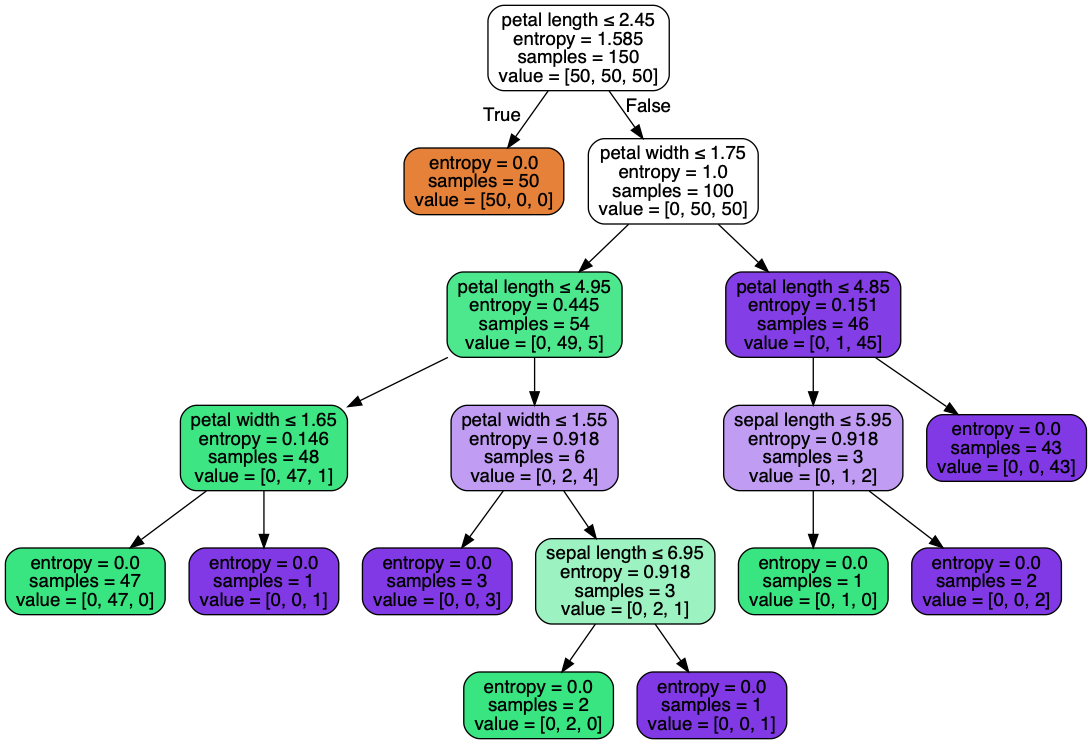

In [79]:
from sklearn import tree
from sklearn.datasets import load_iris
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

data = load_iris()
c45 = tree.DecisionTreeClassifier(criterion="entropy")
c45.fit(data.data, data.target)
y_pred = c45.predict(data.data)

dot_data = StringIO()
export_graphviz(c45, out_file=dot_data,  
                filled=True, rounded=True,
                feature_names=["sepal length","sepal width","petal length", "petal width"],
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

As you can see, the decision tree breaks the data into buckets of data.  Essentially segmenting the dataset such that the entropy is minimized.  The notion here is that data with low entropy is highly ordered.  In doing this ordering, the final nodes are all of one class.  So tracing from the top of the tree to the bottom, we can sort every single row based on the rules that decide how the information flows from root to leaf.

**Note**: that Entropy includes a logarithm in it's computation, so trees are well suited for big datasets.  Typically they aren't useful for less than 100 data points.

## Psuedo Code

Now that we understand approximately how Decision Trees work, let's look at the psuedo code so we can see how Entropy is used:

1. Start at the root node.
2. For each X: 

    find $\{S\}$ s.t. $\sum_{ni \in CN} $

    choose split st. split $\{X \in S\}$ 

    gives minimum overall $\{X \in S\}$
    

3. If a stopping criterion is reached, exit. Otherwise, apply step 2 to each child node in turn.


where ni is node impurity
where CN is child Nodes

As you can see the basic notion is to find the split that minimizes the sum of the impurity for the resultant child nodes.  Trees can basically be seen as a recursive algorithm, where we keep going until we reach some stopping criteria.

Reference:

* [gini implementation](https://medium.com/machine-learning-101/chapter-3-decision-trees-theory-e7398adac567)
* [entropy implementation](https://medium.com/@rakendd/decision-tree-from-scratch-9e23bcfb4928)

## Implementation

Now that we've look at the psuedo code, let's look at a naive implementation of the decision tree classification algorithm:

In [84]:
import numpy as np
import pandas as pd
eps = np.finfo(float).eps
from numpy import log2 as log

def find_entropy(df):
    Class = df.keys()[-1]   #To make the code generic, changing target variable class name
    entropy = 0
    values = df[Class].unique()
    for value in values:
        fraction = df[Class].value_counts()[value]/len(df[Class])
        entropy += -fraction*np.log2(fraction)
    return entropy
  
def find_entropy_attribute(df,attribute):
    Class = df.keys()[-1]   #To make the code generic, changing target variable class name
    target_variables = df[Class].unique()  #This gives all 'Yes' and 'No'
    variables = df[attribute].unique()    #This gives different features in that attribute (like 'Hot','Cold' in Temperature)
    entropy2 = 0
    for variable in variables:
        entropy = 0
        for target_variable in target_variables:
            num = len(df[attribute][df[attribute]==variable][df[Class] ==target_variable])
            den = len(df[attribute][df[attribute]==variable])
            fraction = num/(den+eps)
            entropy += -fraction*log(fraction+eps)
        fraction2 = den/len(df)
        entropy2 += -fraction2*entropy
    return abs(entropy2)


def find_winner(df):
    Entropy_att = []
    IG = []
    for key in df.keys()[:-1]:
#         Entropy_att.append(find_entropy_attribute(df,key))
        IG.append(find_entropy(df)-find_entropy_attribute(df,key))
    return df.keys()[:-1][np.argmax(IG)]
  
def get_subtable(df, node,value):
    return df[df[node] == value].reset_index(drop=True)

def buildTree(df,tree=None): 
    Class = df.keys()[-1]   #To make the code generic, changing target variable class name
    
    #Here we build our decision tree

    #Get attribute with maximum information gain
    node = find_winner(df)
    
    #Get distinct value of that attribute e.g Salary is node and Low,Med and High are values
    attValue = np.unique(df[node])
    
    #Create an empty dictionary to create tree    
    if tree is None:                    
        tree={}
        tree[node] = {}
    
   #We make loop to construct a tree by calling this function recursively. 
    #In this we check if the subset is pure and stops if it is pure. 

    for value in attValue:
        
        subtable = get_subtable(df,node,value)
        clValue,counts = np.unique(subtable['Eat'],return_counts=True)                        
        
        if len(counts)==1:#Checking purity of subset
            tree[node][value] = clValue[0]                                                    
        else:        
            tree[node][value] = buildTree(subtable) #Calling the function recursively 
                   
    return tree

def predict(inst,tree):
    #This function is used to predict for any input variable 
    
    #Recursively we go through the tree that we built earlier

    for nodes in tree.keys():        
        
        value = inst[nodes]
        tree = tree[nodes][value]
        prediction = 0
            
        if type(tree) is dict:
            prediction = predict(inst, tree)
        else:
            prediction = tree
            break;                            
        
    return prediction

dataset = {'Taste':['Salty','Spicy','Spicy','Spicy','Spicy','Sweet','Salty','Sweet','Spicy','Salty'],
       'Temperature':['Hot','Hot','Hot','Cold','Hot','Cold','Cold','Hot','Cold','Hot'],
       'Texture':['Soft','Soft','Hard','Hard','Hard','Soft','Soft','Soft','Soft','Hard'],
       'Eat':['No','No','Yes','No','Yes','Yes','No','Yes','Yes','Yes']}

df = pd.DataFrame(dataset,columns=['Taste','Temperature','Texture','Eat'])
tree = buildTree(df,tree=None)
data = {"Taste": "Salty", "Temperature": "Cold", "Texture": "Hard"}
example = pd.Series(data)
prediction = predict(example, tree)
prediction

'Yes'